In [1]:
import torch
import scvelo as scv
import numpy as np
import scanpy as sc

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (7, 7)
mpl.rcParams['figure.dpi'] = 100

In [3]:
from autoencoder import Autoencoder, train_autoencoder

In [4]:
adata = scv.datasets.pancreas()
adata

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

In [5]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:06) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)


In [6]:
scv.tl.velocity(adata)

computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [7]:
adata.obsm['X_and_velocity'] = np.hstack((adata.X.toarray(), adata.layers['velocity']))

In [8]:
autoencoder = Autoencoder(adata.n_vars, 100)

In [9]:
LR = 0.005
BATCH_SIZE = 40
N_EPOCHS = 50

In [10]:
train_autoencoder(adata.X.toarray(), autoencoder, LR, BATCH_SIZE, N_EPOCHS)

Epoch: 0 -- total train loss: 327.1705
Epoch: 1 -- total train loss: 244.0800
Epoch: 2 -- total train loss: 238.0351
Epoch: 3 -- total train loss: 237.1661
Epoch: 4 -- total train loss: 228.5040
Epoch: 5 -- total train loss: 226.9976
Epoch: 6 -- total train loss: 224.9074
Epoch: 7 -- total train loss: 223.1369
Epoch: 8 -- total train loss: 222.5003
Epoch: 9 -- total train loss: 219.2686
Epoch: 10 -- total train loss: 220.1054
Epoch: 11 -- total train loss: 217.6766
Epoch: 12 -- total train loss: 213.5407
Epoch: 13 -- total train loss: 214.9980
Epoch: 14 -- total train loss: 211.8757
Epoch: 15 -- total train loss: 207.7819
Epoch: 16 -- total train loss: 206.8991
Epoch: 17 -- total train loss: 205.0748
Epoch: 18 -- total train loss: 205.2310
Epoch: 19 -- total train loss: 203.1098
Epoch: 20 -- total train loss: 202.1437
Epoch: 21 -- total train loss: 202.0725
Epoch: 22 -- total train loss: 200.8488
Epoch: 23 -- total train loss: 201.3373
Epoch: 24 -- total train loss: 200.3679
Epoch: 25 

In [11]:
encoded, decoded = autoencoder(torch.from_numpy(adata.X.toarray()))

In [12]:
adata.obsm['X_enc'] = encoded.data.numpy()

In [13]:
autoencoder = Autoencoder(adata.n_vars, 100)

In [14]:
train_autoencoder(adata.layers['velocity'], autoencoder, LR, BATCH_SIZE, N_EPOCHS)

Epoch: 0 -- total train loss: 80.5718
Epoch: 1 -- total train loss: 66.1154
Epoch: 2 -- total train loss: 57.7346
Epoch: 3 -- total train loss: 56.6528
Epoch: 4 -- total train loss: 50.6752
Epoch: 5 -- total train loss: 51.9090
Epoch: 6 -- total train loss: 49.0917
Epoch: 7 -- total train loss: 48.1372
Epoch: 8 -- total train loss: 46.1257
Epoch: 9 -- total train loss: 43.8433
Epoch: 10 -- total train loss: 42.2436
Epoch: 11 -- total train loss: 42.1516
Epoch: 12 -- total train loss: 40.7708
Epoch: 13 -- total train loss: 41.5753
Epoch: 14 -- total train loss: 39.9123
Epoch: 15 -- total train loss: 39.8508
Epoch: 16 -- total train loss: 40.1901
Epoch: 17 -- total train loss: 38.3400
Epoch: 18 -- total train loss: 38.8930
Epoch: 19 -- total train loss: 37.1961
Epoch: 20 -- total train loss: 35.5683
Epoch: 21 -- total train loss: 37.6525
Epoch: 22 -- total train loss: 35.2620
Epoch: 23 -- total train loss: 40.1873
Epoch: 24 -- total train loss: 36.7077
Epoch: 25 -- total train loss: 36.2

In [15]:
encoded, decoded = autoencoder(torch.from_numpy(adata.layers['velocity']))

In [16]:
adata.obsm['Vel_enc'] = encoded.data.numpy()

In [17]:
n_vars = adata.obsm['X_and_velocity'].shape[1]
autoencoder = Autoencoder(n_vars, 100)

In [18]:
train_autoencoder(adata.obsm['X_and_velocity'], autoencoder, LR, BATCH_SIZE, N_EPOCHS)

Epoch: 0 -- total train loss: 368.3053
Epoch: 1 -- total train loss: 348.3107
Epoch: 2 -- total train loss: 309.6195
Epoch: 3 -- total train loss: 300.6222
Epoch: 4 -- total train loss: 294.0048
Epoch: 5 -- total train loss: 284.6191
Epoch: 6 -- total train loss: 281.7613
Epoch: 7 -- total train loss: 276.2163
Epoch: 8 -- total train loss: 268.3359
Epoch: 9 -- total train loss: 267.1415
Epoch: 10 -- total train loss: 262.9681
Epoch: 11 -- total train loss: 263.6887
Epoch: 12 -- total train loss: 263.1334
Epoch: 13 -- total train loss: 259.6909
Epoch: 14 -- total train loss: 254.2996
Epoch: 15 -- total train loss: 256.2323
Epoch: 16 -- total train loss: 253.2690
Epoch: 17 -- total train loss: 257.0121
Epoch: 18 -- total train loss: 250.5951
Epoch: 19 -- total train loss: 248.2182
Epoch: 20 -- total train loss: 249.1223
Epoch: 21 -- total train loss: 249.7121
Epoch: 22 -- total train loss: 246.9909
Epoch: 23 -- total train loss: 250.1049
Epoch: 24 -- total train loss: 246.8484
Epoch: 25 

In [19]:
encoded, decoded = autoencoder(torch.from_numpy(adata.obsm['X_and_velocity']))

In [20]:
adata.obsm['X_Vel_enc'] = encoded.data.numpy()

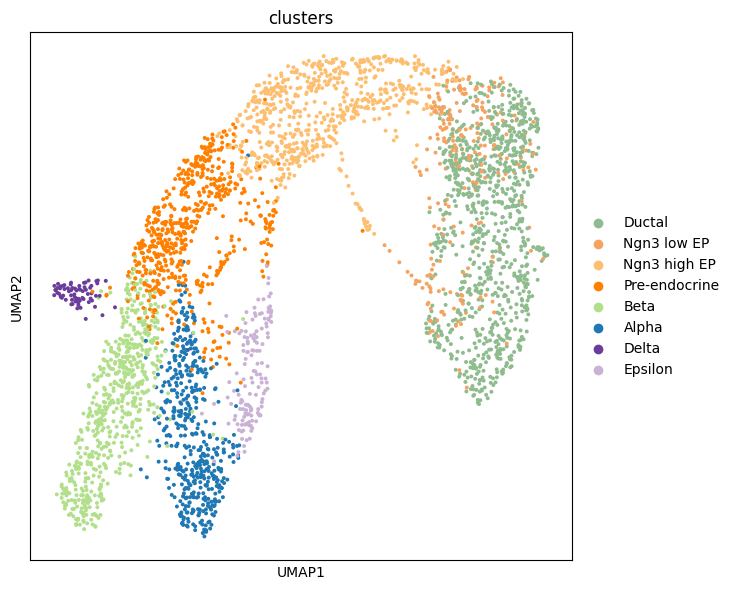

In [21]:
sc.pp.neighbors(adata, use_rep='X_enc')
sc.tl.umap(adata)
sc.pl.umap(adata, color='clusters')

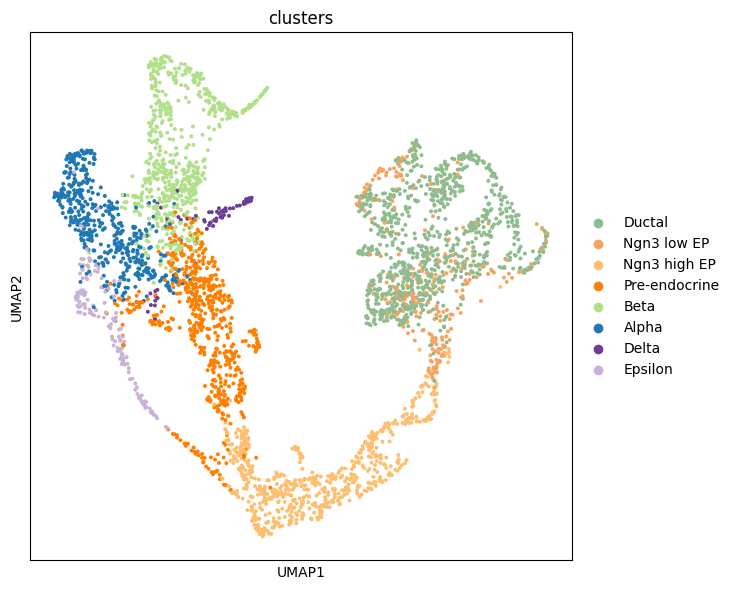

In [22]:
sc.pp.neighbors(adata, use_rep='Vel_enc')
sc.tl.umap(adata)
sc.pl.umap(adata, color='clusters')

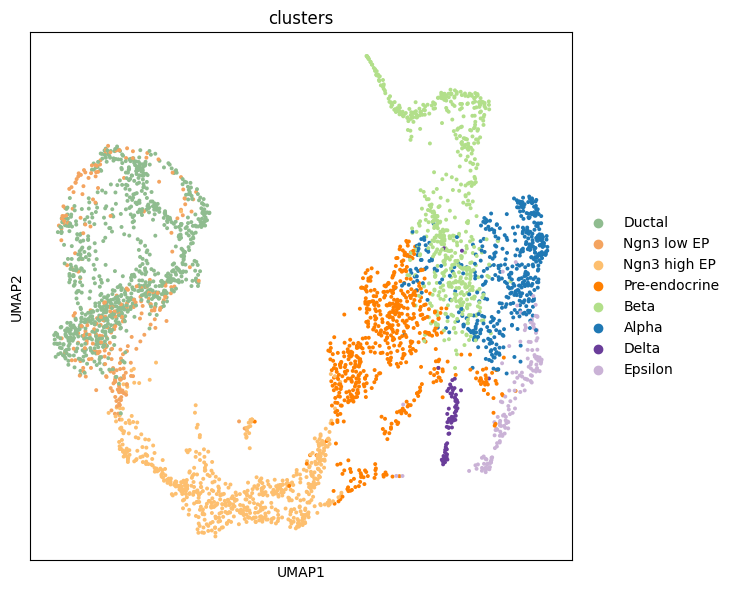

In [23]:
sc.pp.neighbors(adata, use_rep='X_and_velocity')
sc.tl.umap(adata)
sc.pl.umap(adata, color='clusters')

In [24]:
adata.write('pancreas_vels_aut.h5ad')